In [219]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.dates as mdates

In [220]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [221]:
# Load COVID-19 case data
# TODO: download most recent data
raw = pd.read_csv('05-05-2020.csv')

# Drop unnecessary columns and remove all regions that are not US counties
raw = raw.drop(['FIPS', 'Last_Update', 'Long_'], axis=1)
raw.drop(raw[raw['Country_Region'] != 'US'].index, inplace=True)
raw.dropna(inplace=True)

# Rename columns
raw.rename(columns={'Lat':'Latitude', 'Combined_Key': 'County'},inplace=True)

# Filter out counties with less than min_sample_size
min_sample_size = 5000
raw = raw[raw['Confirmed'] >= min_sample_size]

def update_county_names(x):
    x = x[:-4]
    
    for a in us_state_abbrev.keys():
        if a in x:
            index = -1 * len(a)
            x = x[:index]
            x = x + us_state_abbrev[a]
    
    return x
    
raw['County'] = raw['County'].apply(update_county_names)

# Set 'County' as index
raw = raw.groupby('County').sum()

raw

,Latitude,Confirmed,Deaths,Recovered,Active
County,,,,,
"Bergen, NJ",40.960109,16460,1261,0,15199
"Broward, FL",26.151847,5492,215,0,5277
"Cook, IL",41.841448,45223,1922,0,43301
"District of Columbia, DC",38.904178,5322,264,0,5058
"Essex, MA",42.668763,9979,527,0,9452
"Essex, NJ",40.786813,14840,1319,0,13521
"Fairfield, CT",41.268099,12360,935,0,11425
"Harris, TX",29.860000,7128,144,0,6984
"Hartford, CT",41.802830,6351,804,0,5547


In [222]:
# Load county geographical data
def load_geo_data(file, dropCols, dropRows, indexCol):
    df = pd.read_csv(file)
    for d in dropRows.keys():
        df.drop(df[df[d] != dropRows[d]].index, inplace=True)
    df.drop(dropCols, axis=1, inplace=True)
    df.dropna(inplace=True)
    df[indexCol] = df[indexCol].apply(lambda x: x.replace(' County', ''))
    df.set_index(indexCol, drop=True, inplace=True)
    
    return df

# Load temperature data
temp = load_geo_data('North America Land Data Assimilation System (NLDAS) Daily Air Temperatures and Heat Index (1979-2011).csv', 
                     ['County Code', 'Avg Daily Max Air Temperature (C)', 'Avg Daily Min Air Temperature (C)'], {}, 'County')
temp

# Load heat index data
# Heat index = "how hot it really feels when relative humidity is factored in with the actual air temperature"
heat_index = load_geo_data('North America Land Data Assimilation System (NLDAS) Daily Air Temperatures and Heat Index (1979-2011)-2.csv',
                           ['County Code'], {}, 'County')
heat_index = heat_index[heat_index['Avg Max Heat Index (C)'] != 'Missing']
heat_index['Avg Max Heat Index (C)'] = heat_index['Avg Max Heat Index (C)'].apply(lambda x: float(x))
heat_index

# Load unemployment data
unemploy = load_geo_data('Unemployment.csv', ['FIPS', 'State', 'Rural_urban_continuum_code_2013', 'Urban_influence_code_2013',
       'Metro_2013', ' Civilian_labor_force_2007 ', ' Employed_2007 ',
       ' Unemployed_2007 ', 'Unemployment_rate_2007',
       ' Civilian_labor_force_2008 ', ' Employed_2008 ', ' Unemployed_2008 ',
       'Unemployment_rate_2008', 'Civilian_labor_force_2009', 'Employed_2009',
       'Unemployed_2009', 'Unemployment_rate_2009',
       ' Civilian_labor_force_2010 ', ' Employed_2010 ', ' Unemployed_2010 ',
       'Unemployment_rate_2010', ' Civilian_labor_force_2011 ',
       ' Employed_2011 ', ' Unemployed_2011 ', 'Unemployment_rate_2011',
       ' Civilian_labor_force_2012 ', ' Employed_2012 ', ' Unemployed_2012 ',
       'Unemployment_rate_2012', ' Civilian_labor_force_2013 ',
       ' Employed_2013 ', ' Unemployed_2013 ', 'Unemployment_rate_2013',
       ' Civilian_labor_force_2014 ', ' Employed_2014 ', ' Unemployed_2014 ',
       'Unemployment_rate_2014', ' Civilian_labor_force_2015 ',
       ' Employed_2015 ', ' Unemployed_2015 ', 'Unemployment_rate_2015',
       ' Civilian_labor_force_2016 ', ' Employed_2016 ', ' Unemployed_2016 ',
       'Unemployment_rate_2016', 'Civilian_labor_force_2017', 'Employed_2017',
       'Unemployed_2017', 'Unemployment_rate_2017'], {},'Area_name')
unemploy

# Load poverty data
poverty = load_geo_data('PovertyRate.csv', ['Area_name', 'State', 'POVALL_2018', 'POP_ESTIMATE_2018'], {}, 'County')
poverty.rename({'Unnamed: 5': 'Poverty Rate'}, axis=1, inplace=True)
poverty

# Load population data
population = load_geo_data('PopulationEstimates.csv', ['FIPS', 'State', 'Area_Name'], {}, 'County')
population

# Load presidential voting data
# Source: https://electionlab.mit.edu/data
pres_vote = load_geo_data('countypres_2000-2016.csv', ['state', 'state_po', 'county_short', 'FIPS', 'candidate',
                        'office', 'year', 'party'], {'party': 'democrat'}, 'County')
pres_vote

,candidatevotes,totalvotes,% Democrat Votes (of major parties),% Democrat Votes
County,,,,
"Autauga, AL",5936.0,24973,0.246225319,0.237696712
"Baldwin, AL",18458.0,95215,0.202077928,0.19385601
"Barbour, AL",4871.0,10469,0.471767554,0.465278441
"Bibb, AL",1874.0,8819,0.217603344,0.212495748
"Blount, AL",2156.0,25588,0.086188287,0.084258246
...,...,...,...,...
"District 37, AK",2421.0,5062,0.555402615,0.478269459
"District 38, AK",2758.0,5095,0.706998206,0.541315015
"District 39, AK",3142.0,5639,0.691005058,0.557190991


In [223]:
# Calculate death rate for each country
def cal_death_rate(total_deaths, total_confirmed):
    death_rate = pd.Series(dtype = float)
    
    # Calculating death rate
    if (total_deaths.index == total_confirmed.index).all():
        death_rate = total_deaths/(total_confirmed + total_deaths)
    else:
        print('Whoops, looks like your countries dont match')
    
    # Drop countries that have a null death rate (don't have any cases)
    death_rate.dropna(inplace=True)
    
    death_rate = pd.DataFrame(death_rate)
    death_rate.rename(columns={death_rate.columns[0]:'Death Rate'},inplace=True)
    
    return death_rate

# Get most recent numbers for comfirmed and deaths
total_confirmed = raw['Confirmed']
total_deaths = raw['Deaths']

# Calculate death rate
death_rate = cal_death_rate(total_deaths, total_confirmed)

death_rate

,Death Rate
County,
"Bergen, NJ",0.071159
"Broward, FL",0.037673
"Cook, IL",0.040768
"District of Columbia, DC",0.047261
"Essex, MA",0.050162
"Essex, NJ",0.081626
"Fairfield, CT",0.070327
"Harris, TX",0.019802
"Hartford, CT",0.112369


In [224]:
# Merge two data sets
def merge_data1(covid_data, geo_data):
    df = geo_data.merge(covid_data, left_index=True, right_index=True)
    
    # Check missing countries
    print(f'We lost {covid_data.shape[0] - df.shape[0]} counties in our merge')
    
    return df
    

def merge_data2(covid_data, raw):
    df = pd.concat([raw, covid_data], axis=1)
    df = df.drop(['Confirmed', 'Deaths', 'Recovered', 'Active'], axis=1)
    return df

# Death rates and latitude
death_and_lat = merge_data2(death_rate, raw)
death_and_lat.describe()

# Death rates and temperature
death_and_temp = merge_data1(death_rate, temp)
death_and_temp

# Death rates and heat index
death_and_heatindex = merge_data1(death_rate, heat_index)
death_and_heatindex

# Death rates and unemployment rate
unemploy1 = unemploy.drop(['Civilian_labor_force_2018', 'Employed_2018', 'Unemployed_2018',
       'Median_Household_Income_2018', 'Med_HH_Income_Percent_of_State_Total_2018'], axis=1)
death_and_unemploy = merge_data1(death_rate, unemploy1)
death_and_unemploy.rename(columns={'Unemployment_rate_2018':'Unemployment Rate'},inplace=True)
death_and_unemploy

def update_income(x):
    x = x.replace('$', '')
    x = x.replace(',', '')
    return int(x)
    
# Death rates and median income
unemploy2 = unemploy.drop(['Civilian_labor_force_2018', 'Employed_2018', 'Unemployed_2018',
       'Unemployment_rate_2018', 'Med_HH_Income_Percent_of_State_Total_2018'], axis=1)
death_and_income = merge_data1(death_rate, unemploy2)
death_and_income.rename(columns={'Median_Household_Income_2018':'Median Household Income ($)'},inplace=True)
death_and_income['Median Household Income ($)'] = death_and_income['Median Household Income ($)'].apply(update_income)
death_and_income

# Death rates and income percent of state
unemploy3 = unemploy.drop(['Civilian_labor_force_2018', 'Employed_2018', 'Unemployed_2018',
       'Unemployment_rate_2018', 'Median_Household_Income_2018'], axis=1)
death_and_incomepercent = merge_data1(death_rate, unemploy3)
death_and_incomepercent.rename(columns={'Med_HH_Income_Percent_of_State_Total_2018':'Median HH Income Percent of State Total'},inplace=True)
death_and_incomepercent

# Death rates and poverty rate
death_and_povrate = merge_data1(death_rate, poverty)
death_and_povrate

# Death rates and urban influence codes
# https://www.ers.usda.gov/data-products/urban-influence-codes.aspx
population1 = population.drop(['Rural-urban_Continuum Code_2003', 'Rural-urban_Continuum Code_2013',
       'Urban_Influence_Code_2003', 'Economic_typology_2015', 'POP_ESTIMATE_2018', 'N_POP_CHG_2018',
       'Births_2018', 'Deaths_2018', 'NATURAL_INC_2018', 'INTERNATIONAL_MIG_2018', 'DOMESTIC_MIG_2018',
       'NET_MIG_2018', 'RESIDUAL_2018', 'GQ_ESTIMATES_2018'], axis=1)
death_and_urbinfl = merge_data1(death_rate, population1)
death_and_urbinfl.rename(columns={'Urban_Influence_Code_2013': 'Urban Influence Code'},inplace=True)
death_and_urbinfl

# Death rates and 2016 % Democrat presidential votes
presvote1 = presvote.drop(['candidatevotes', 'totalvotes', '% Democrat Votes (of major parties)'], axis=1)
death_and_demo = merge_data1(death_rate, presvote1)
death_and_demo.rename(columns={'% Democrat Votes': '% Democrat Votes in 2016 Elections'},inplace=True)
death_and_demo['% Democrat Votes in 2016 Elections'] = death_and_demo['% Democrat Votes in 2016 Elections'].apply(lambda x: float(x))
death_and_demo

We lost 4 counties in our merge
We lost 4 counties in our merge
We lost 5 counties in our merge
We lost 5 counties in our merge
We lost 5 counties in our merge
We lost 2 counties in our merge
We lost 3 counties in our merge
We lost 1 counties in our merge


,% Democrat Votes in 2016 Elections,Death Rate
County,,
"Bergen, NJ",0.551427,0.071159
"Broward, FL",0.665087,0.037673
"Cook, IL",0.746750,0.040768
"District of Columbia, DC",0.908638,0.047261
"Essex, MA",0.585230,0.050162
"Essex, NJ",0.774560,0.081626
"Fairfield, CT",0.578933,0.070327
"Harris, TX",0.539523,0.019802
"Hartford, CT",0.590868,0.112369


In [225]:
# Plot linear regression
def lin_regress(merged_data, col_death, col_data, start, line_length):
    # Linear regression using scipy
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged_data[col_data], merged_data[col_death])
    predictions = np.linspace(start,line_length,5) * slope + intercept
    
    # Visualize using plt
    plt.scatter(merged_data[col_data], merged_data[col_death])
    plt.ylabel(col_death)
    plt.xlabel(col_data)
    plt.title(f'{col_death} vs {col_data}')
    plt.plot(np.linspace(start,line_length,5), predictions)
    plt.show()
    
    # Print important values
    print(f'p-values: {p_value}')
    print(f'R^2: {r_value*r_value}')
    print(f'Slope: {slope}')

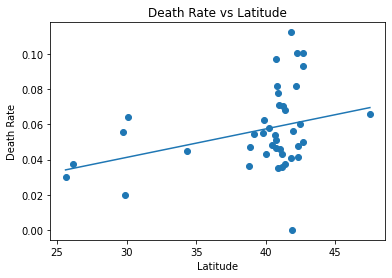

p-values: 0.03688776035823032
R^2: 0.10694645418978166
Slope: 0.0016183989222999038


In [226]:
lin_regress(death_and_lat, 'Death Rate', 'Latitude', death_and_lat['Latitude'].min(), death_and_lat['Latitude'].max())

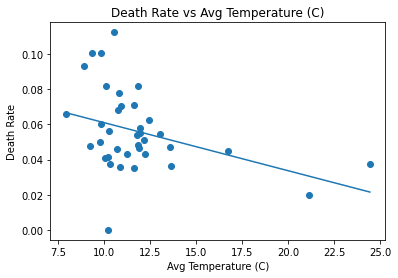

p-values: 0.02270903985908932
R^2: 0.1396446930508946
Slope: -0.002731496192405999


In [227]:
lin_regress(death_and_temp, 'Death Rate', 'Avg Temperature (C)', death_and_temp['Avg Temperature (C)'].min(), death_and_temp['Avg Temperature (C)'].max())

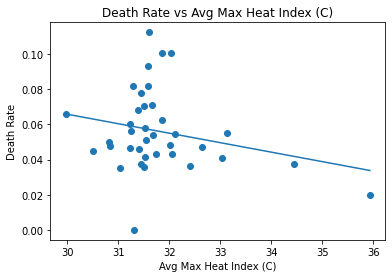

p-values: 0.14355563056831558
R^2: 0.060118230230872
Slope: -0.005396814729671787


In [228]:
lin_regress(death_and_heatindex, 'Death Rate', 'Avg Max Heat Index (C)', death_and_heatindex['Avg Max Heat Index (C)'].min(), death_and_heatindex['Avg Max Heat Index (C)'].max())

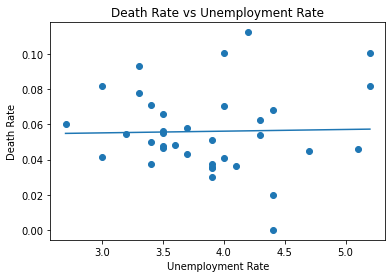

p-values: 0.8857321911385705
R^2: 0.0006162059065298455
Slope: 0.0009683473724064189


In [229]:
lin_regress(death_and_unemploy, 'Death Rate', 'Unemployment Rate', death_and_unemploy['Unemployment Rate'].min(), death_and_unemploy['Unemployment Rate'].max())

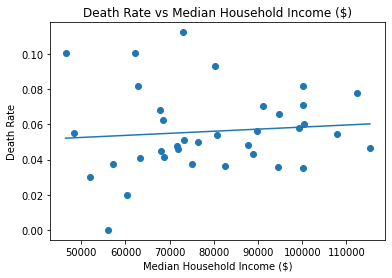

p-values: 0.5892700776021076
R^2: 0.008662265212042981
Slope: 1.1812249399171904e-07


In [230]:
lin_regress(death_and_income, 'Death Rate', 'Median Household Income ($)', death_and_income['Median Household Income ($)'].min(), death_and_income['Median Household Income ($)'].max())

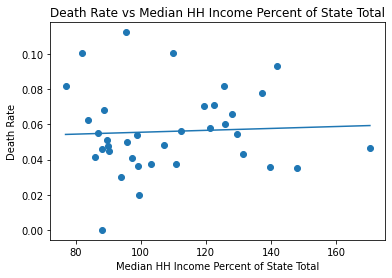

p-values: 0.7666834908403557
R^2: 0.0026243170142647345
Slope: 5.404703471296529e-05


In [231]:
lin_regress(death_and_incomepercent, 'Death Rate', 'Median HH Income Percent of State Total', death_and_incomepercent['Median HH Income Percent of State Total'].min(), death_and_incomepercent['Median HH Income Percent of State Total'].max())

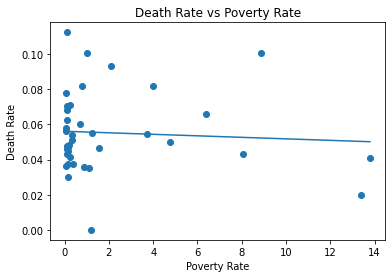

p-values: 0.6864612834343076
R^2: 0.004453803054790089
Slope: -0.00042998116911221367


In [232]:
lin_regress(death_and_povrate, 'Death Rate', 'Poverty Rate', death_and_povrate['Poverty Rate'].min(), death_and_povrate['Poverty Rate'].max())

In [ ]:
lin_regress(death_and_urbinfl, 'Death Rate', 'Urban Influence Code', death_and_urbinfl['Urban Influence Code'].min(), death_and_urbinfl['Urban Influence Code'].max())

In [ ]:
lin_regress(death_and_demo, 'Death Rate', '% Democrat Votes in 2016 Elections', death_and_demo['% Democrat Votes in 2016 Elections'].min(), death_and_demo['% Democrat Votes in 2016 Elections'].max())